In [ ]:
# Importa√ß√µes necess√°rias
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Configura√ß√£o para reprodutibilidade
np.random.seed(42)
keras.utils.set_random_seed(42)

print("Keras vers√£o:", keras.__version__)
print("Configura√ß√£o realizada com sucesso!")

In [9]:
# Definindo as fun√ß√µes a serem aproximadas

def function_a(x):
    """Fun√ß√£o a) f(x) = sin(2x) + cos(3x)"""
    return np.sin(2*x) + np.cos(3*x)

def function_b(x):
    """Fun√ß√£o b) f(x) = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2"""
    return 10*x**5 + 5*x**4 + 2*x**3 - 0.5*x**2 + 3*x + 2

# Testando as fun√ß√µes
x_test = np.array([0, 1, 2, 3, 4, 5])
print("Teste da Fun√ß√£o A (sin(2x) + cos(3x)):")
for x_val in x_test:
    print(f"f({x_val}) = {function_a(x_val):.4f}")

print("\nTeste da Fun√ß√£o B (10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2):")
for x_val in x_test:
    print(f"f({x_val}) = {function_b(x_val):.4f}")

Teste da Fun√ß√£o A (sin(2x) + cos(3x)):
f(0) = 1.0000
f(1) = -0.0807
f(2) = 0.2034
f(3) = -1.1905
f(4) = 1.8332
f(5) = -1.3037

Teste da Fun√ß√£o B (10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2):
f(0) = 2.0000
f(1) = 21.5000
f(2) = 422.0000
f(3) = 2895.5000
f(4) = 11654.0000
f(5) = 34629.5000


In [10]:
# Gera√ß√£o dos conjuntos de dados

def generate_dataset(func, x_min=0, x_max=5, n_samples=1000):
    """Gera conjunto de dados para uma fun√ß√£o"""
    x = np.random.uniform(x_min, x_max, n_samples)
    y = func(x)
    return x.reshape(-1, 1), y

# Gerando dados para ambas as fun√ß√µes
print("Gerando conjuntos de dados...")

# Fun√ß√£o A: sin(2x) + cos(3x)
x_a, y_a = generate_dataset(function_a, n_samples=2000)
x_train_a, x_temp_a, y_train_a, y_temp_a = train_test_split(x_a, y_a, test_size=0.4, random_state=42)
x_val_a, x_test_a, y_val_a, y_test_a = train_test_split(x_temp_a, y_temp_a, test_size=0.5, random_state=42)

print(f"Fun√ß√£o A - Treinamento: {len(x_train_a)} amostras")
print(f"Fun√ß√£o A - Valida√ß√£o: {len(x_val_a)} amostras")
print(f"Fun√ß√£o A - Teste: {len(x_test_a)} amostras")

# Fun√ß√£o B: 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2
x_b, y_b = generate_dataset(function_b, n_samples=2000)
x_train_b, x_temp_b, y_train_b, y_temp_b = train_test_split(x_b, y_b, test_size=0.4, random_state=42)
x_val_b, x_test_b, y_val_b, y_test_b = train_test_split(x_temp_b, y_temp_b, test_size=0.5, random_state=42)

print(f"Fun√ß√£o B - Treinamento: {len(x_train_b)} amostras")
print(f"Fun√ß√£o B - Valida√ß√£o: {len(x_val_b)} amostras")
print(f"Fun√ß√£o B - Teste: {len(x_test_b)} amostras")

# Normaliza√ß√£o dos dados para a Fun√ß√£o B (devido aos valores muito grandes)
scaler_x_b = StandardScaler()
scaler_y_b = StandardScaler()

x_train_b_scaled = scaler_x_b.fit_transform(x_train_b)
x_val_b_scaled = scaler_x_b.transform(x_val_b)
x_test_b_scaled = scaler_x_b.transform(x_test_b)

y_train_b_scaled = scaler_y_b.fit_transform(y_train_b.reshape(-1, 1)).flatten()
y_val_b_scaled = scaler_y_b.transform(y_val_b.reshape(-1, 1)).flatten()

print("\nNormaliza√ß√£o aplicada na Fun√ß√£o B devido √† magnitude dos valores")

Gerando conjuntos de dados...
Fun√ß√£o A - Treinamento: 1200 amostras
Fun√ß√£o A - Valida√ß√£o: 400 amostras
Fun√ß√£o A - Teste: 400 amostras
Fun√ß√£o B - Treinamento: 1200 amostras
Fun√ß√£o B - Valida√ß√£o: 400 amostras
Fun√ß√£o B - Teste: 400 amostras

Normaliza√ß√£o aplicada na Fun√ß√£o B devido √† magnitude dos valores


In [ ]:
# Cria√ß√£o dos modelos de perceptron multicamadas

def create_mlp_model(input_dim=1, hidden_layers=[64, 32, 16], activation='relu', output_activation='linear'):
    """
    Cria um modelo de perceptron multicamadas
    
    Args:
        input_dim: dimens√£o de entrada
        hidden_layers: lista com n√∫mero de neur√¥nios em cada camada oculta
        activation: fun√ß√£o de ativa√ß√£o das camadas ocultas
        output_activation: fun√ß√£o de ativa√ß√£o da camada de sa√≠da
    """
    model = Sequential()
    
    # Primeira camada oculta
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation=activation))
    
    # Camadas ocultas adicionais
    for neurons in hidden_layers[1:]:
        model.add(Dense(neurons, activation=activation))
    
    # Camada de sa√≠da
    model.add(Dense(1, activation=output_activation))
    
    return model

# Criando modelos para ambas as fun√ß√µes
print("Criando modelos...")

# Modelo para Fun√ß√£o A
model_a = create_mlp_model(hidden_layers=[64, 32, 16])
model_a.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Modelo para Fun√ß√£o B
model_b = create_mlp_model(hidden_layers=[128, 64, 32, 16], activation='tanh')  # Arquitetura mais complexa para fun√ß√£o polinomial
model_b.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("Modelo A (Fun√ß√£o Trigonom√©trica):")
model_a.summary()

print("\nModelo B (Fun√ß√£o Polinomial):")
model_b.summary()

Criando modelos...
Modelo A (Fun√ß√£o Trigonom√©trica):


Model: "sequential_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 64)             ‚îÇ           128 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 32)             ‚îÇ         2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                 ‚îÇ (None, 16)             ‚îÇ           528 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            17 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)


Modelo B (Fun√ß√£o Polinomial):


Model: "sequential_4"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ dense_5 (Dense)                 ‚îÇ (None, 128)            ‚îÇ           256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_6 (Dense)                 ‚îÇ (None, 64)             ‚îÇ         8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_7 (Dense)                 ‚îÇ (None, 32)             ‚îÇ         2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_8 (Dense)                 ‚îÇ (None, 16)             ‚îÇ           528 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_9 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            17 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Configura√ß√£o dos callbacks
early_stopping_a = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr_a = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

early_stopping_b = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr_b = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

print("Iniciando treinamento...")

# Treinamento do Modelo A (Fun√ß√£o Trigonom√©trica)
print("\nTreinando modelo para Fun√ß√£o A: f(x) = sin(2x) + cos(3x)")
history_a = model_a.fit(
    x_train_a, y_train_a,
    validation_data=(x_val_a, y_val_a),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping_a, reduce_lr_a],
    verbose=1
)

Iniciando treinamento...

Treinando modelo para Fun√ß√£o A: f(x) = sin(2x) + cos(3x)
Epoch 1/200
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step - loss: 0.7828 - mae: 0.7181 - val_loss: 0.7692 - val_mae: 0.7139 - learning_rate: 0.0010
Epoch 2/200
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 5ms/step - loss: 0.7787 - mae: 0.7091 - val_loss: 0.7375 - val_mae: 0.7086 - learning_rate: 0.0010
Epoch 3/200
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 5ms/step - loss: 0.7457 - mae: 0.6967 - val_loss: 0.7052 - val_mae: 0.6758 - learning_rate: 0.0010
Epoch 4/200
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step - loss: 0.7061 - mae: 0.6645 - val_loss: 0.6901 - val_mae: 0.6397 - learning_rate: 0.0010
Epoch 5/200
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step - loss: 0.6820 - mae: 0.6327 - val_loss: 0.6324 - val_mae: 0.5953 - learning_rate: 0.0010
Epoch 6/20

In [13]:
# Treinamento do Modelo B (Fun√ß√£o Polinomial)
print("\nTreinando modelo para Fun√ß√£o B: f(x) = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2")
history_b = model_b.fit(
    x_train_b_scaled, y_train_b_scaled,
    validation_data=(x_val_b_scaled, y_val_b_scaled),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping_b, reduce_lr_b],
    verbose=1
)

print("\nTreinamento conclu√≠do!")


Treinando modelo para Fun√ß√£o B: f(x) = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2
Epoch 1/200
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step - loss: 0.6401 - mae: 0.5623 - val_loss: 0.3114 - val_mae: 0.4013 - learning_rate: 0.0010
Epoch 2/200
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step - loss: 0.1092 - mae: 0.2291 - val_loss: 0.0437 - val_mae: 0.1298 - learning_rate: 0.0010
Epoch 3/200
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step - loss: 0.0222 - mae: 0.0994 - val_loss: 0.0221 - val_mae: 0.1050 - learning_rate: 0.0010
Epoch 4/200
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step - loss: 0.0132 - mae: 0.0795 - val_loss: 0.0137 - val_mae: 0.0767 - learning_rate: 0.0010
Epoch 5/200
38/38 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step - loss: 0.0068 - mae: 0.0553 - val_loss: 0.0133 - val_mae: 0.0604 - learning_rate: 0.0010
Epoch 6/200
38/

In [ ]:
# Avalia√ß√£o dos modelos

def evaluate_model(model, x_test, y_test, model_name, scaler_y=None):
    """Avalia um modelo e retorna m√©tricas"""
    predictions = model.predict(x_test, verbose=0)
    
    if scaler_y is not None:
        predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
    
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"\n{model_name}:")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {np.sqrt(mse):.6f}")
    print(f"R¬≤: {r2:.6f}")
    
    return predictions

# Avalia√ß√£o do Modelo A
print("=== AVALIA√á√ÉO DOS MODELOS ===")
pred_a = evaluate_model(model_a, x_test_a, y_test_a, "Modelo A (Fun√ß√£o Trigonom√©trica)")

# Avalia√ß√£o do Modelo B
pred_b_scaled = model_b.predict(x_test_b_scaled, verbose=0)
pred_b = scaler_y_b.inverse_transform(pred_b_scaled.reshape(-1, 1)).flatten()
mse_b = mean_squared_error(y_test_b, pred_b)
r2_b = r2_score(y_test_b, pred_b)

print(f"\nModelo B (Fun√ß√£o Polinomial):")
print(f"MSE: {mse_b:.6f}")
print(f"RMSE: {np.sqrt(mse_b):.6f}")
print(f"R¬≤: {r2_b:.6f}")

# Salva os modelos
model_a.save("modelo_a.keras")
model_b.save("modelo_b.keras")


=== AVALIA√á√ÉO DOS MODELOS ===

Modelo A (Fun√ß√£o Trigonom√©trica):
MSE: 0.001786
RMSE: 0.042265
R¬≤: 0.997894

Modelo B (Fun√ß√£o Polinomial):
MSE: 1125.093965
RMSE: 33.542420
R¬≤: 0.999986


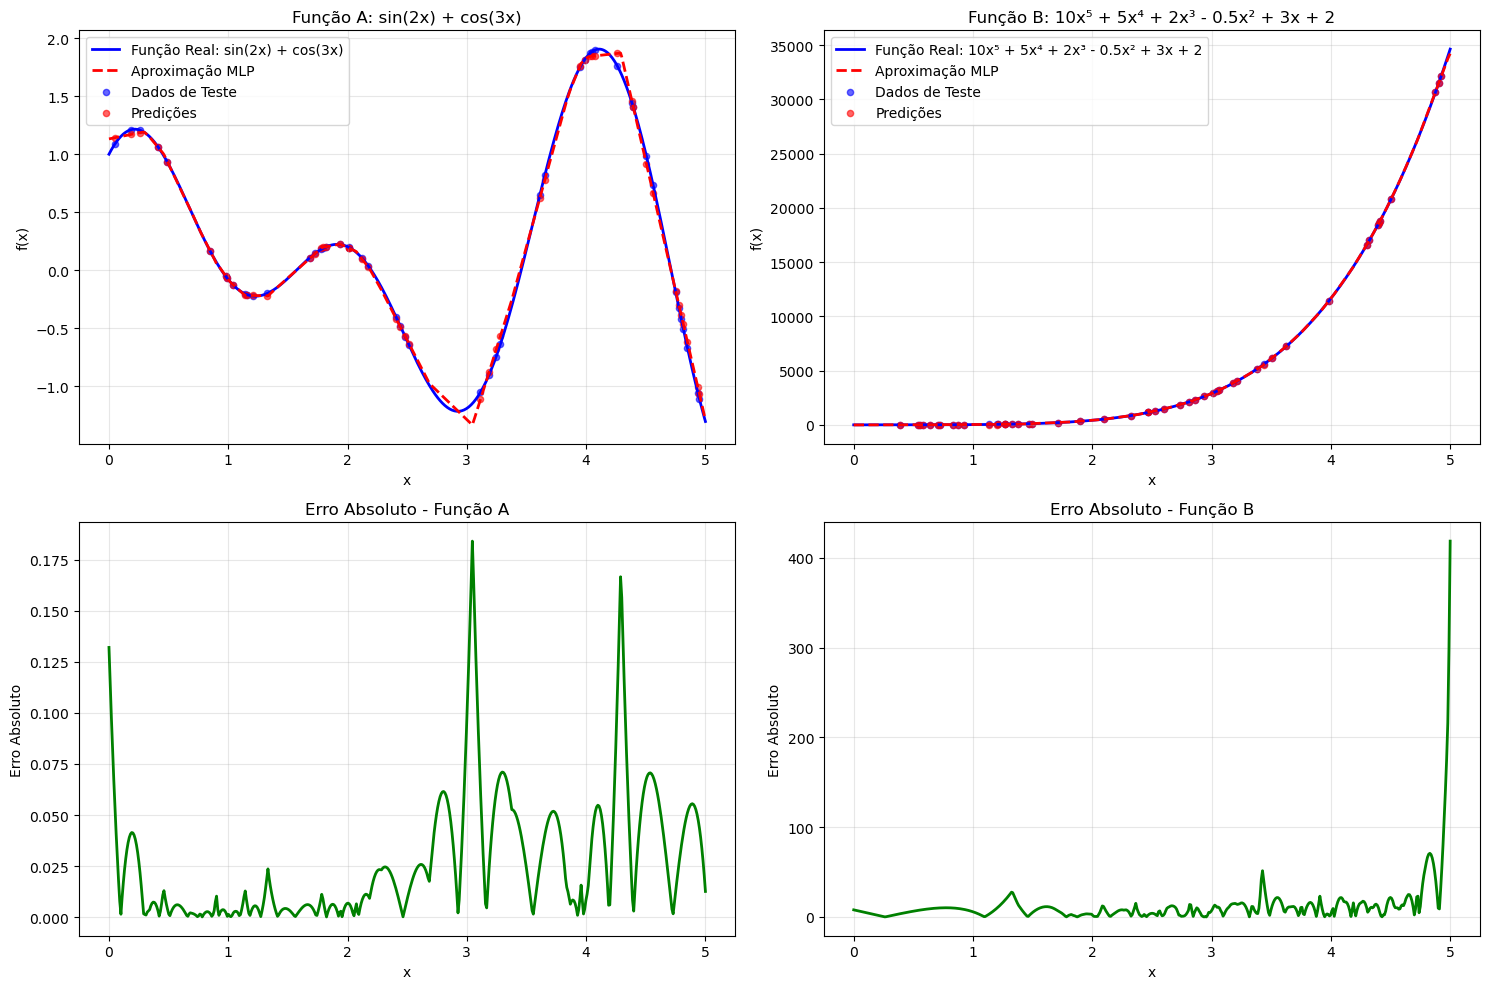

In [15]:
# Visualiza√ß√£o das fun√ß√µes reais vs aproximadas

# Gerando pontos para plotagem suave
x_plot = np.linspace(0, 5, 500).reshape(-1, 1)

# Fun√ß√£o A - Predi√ß√µes
y_real_a = function_a(x_plot.flatten())
pred_plot_a = model_a.predict(x_plot, verbose=0).flatten()

# Fun√ß√£o B - Predi√ß√µes
y_real_b = function_b(x_plot.flatten())
x_plot_b_scaled = scaler_x_b.transform(x_plot)
pred_plot_b_scaled = model_b.predict(x_plot_b_scaled, verbose=0)
pred_plot_b = scaler_y_b.inverse_transform(pred_plot_b_scaled.reshape(-1, 1)).flatten()

# Criando os gr√°ficos
plt.figure(figsize=(15, 10))

# Gr√°fico para Fun√ß√£o A
plt.subplot(2, 2, 1)
plt.plot(x_plot, y_real_a, 'b-', label='Fun√ß√£o Real: sin(2x) + cos(3x)', linewidth=2)
plt.plot(x_plot, pred_plot_a, 'r--', label='Aproxima√ß√£o MLP', linewidth=2)
plt.scatter(x_test_a[:50], y_test_a[:50], c='blue', alpha=0.6, s=20, label='Dados de Teste')
plt.scatter(x_test_a[:50], pred_a[:50], c='red', alpha=0.6, s=20, label='Predi√ß√µes')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Fun√ß√£o A: sin(2x) + cos(3x)')
plt.legend()
plt.grid(True, alpha=0.3)

# Gr√°fico para Fun√ß√£o B
plt.subplot(2, 2, 2)
plt.plot(x_plot, y_real_b, 'b-', label='Fun√ß√£o Real: 10x‚Åµ + 5x‚Å¥ + 2x¬≥ - 0.5x¬≤ + 3x + 2', linewidth=2)
plt.plot(x_plot, pred_plot_b, 'r--', label='Aproxima√ß√£o MLP', linewidth=2)
plt.scatter(x_test_b[:50], y_test_b[:50], c='blue', alpha=0.6, s=20, label='Dados de Teste')
plt.scatter(x_test_b[:50], pred_b[:50], c='red', alpha=0.6, s=20, label='Predi√ß√µes')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Fun√ß√£o B: 10x‚Åµ + 5x‚Å¥ + 2x¬≥ - 0.5x¬≤ + 3x + 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Gr√°fico de erro para Fun√ß√£o A
plt.subplot(2, 2, 3)
error_a = np.abs(y_real_a - pred_plot_a)
plt.plot(x_plot, error_a, 'g-', linewidth=2)
plt.xlabel('x')
plt.ylabel('Erro Absoluto')
plt.title('Erro Absoluto - Fun√ß√£o A')
plt.grid(True, alpha=0.3)

# Gr√°fico de erro para Fun√ß√£o B
plt.subplot(2, 2, 4)
error_b = np.abs(y_real_b - pred_plot_b)
plt.plot(x_plot, error_b, 'g-', linewidth=2)
plt.xlabel('x')
plt.ylabel('Erro Absoluto')
plt.title('Erro Absoluto - Fun√ß√£o B')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

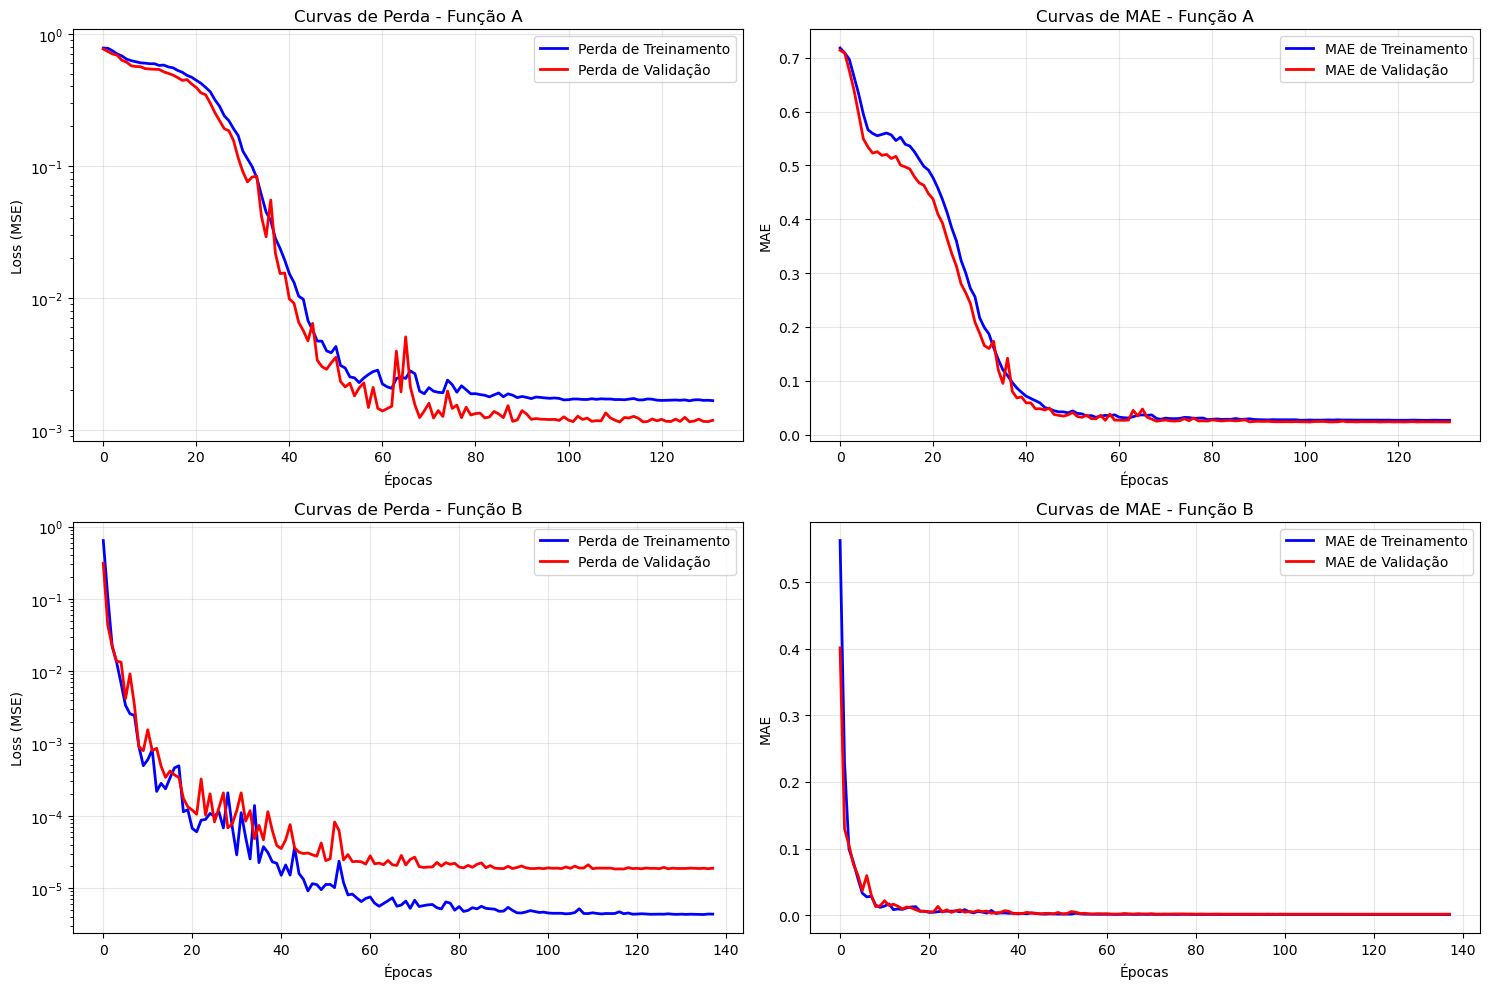

In [16]:
# Curvas de aprendizado (Loss e MAE)

plt.figure(figsize=(15, 10))

# Curvas de perda para Fun√ß√£o A
plt.subplot(2, 2, 1)
plt.plot(history_a.history['loss'], 'b-', label='Perda de Treinamento', linewidth=2)
plt.plot(history_a.history['val_loss'], 'r-', label='Perda de Valida√ß√£o', linewidth=2)
plt.xlabel('√âpocas')
plt.ylabel('Loss (MSE)')
plt.title('Curvas de Perda - Fun√ß√£o A')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Curvas de MAE para Fun√ß√£o A
plt.subplot(2, 2, 2)
plt.plot(history_a.history['mae'], 'b-', label='MAE de Treinamento', linewidth=2)
plt.plot(history_a.history['val_mae'], 'r-', label='MAE de Valida√ß√£o', linewidth=2)
plt.xlabel('√âpocas')
plt.ylabel('MAE')
plt.title('Curvas de MAE - Fun√ß√£o A')
plt.legend()
plt.grid(True, alpha=0.3)

# Curvas de perda para Fun√ß√£o B
plt.subplot(2, 2, 3)
plt.plot(history_b.history['loss'], 'b-', label='Perda de Treinamento', linewidth=2)
plt.plot(history_b.history['val_loss'], 'r-', label='Perda de Valida√ß√£o', linewidth=2)
plt.xlabel('√âpocas')
plt.ylabel('Loss (MSE)')
plt.title('Curvas de Perda - Fun√ß√£o B')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Curvas de MAE para Fun√ß√£o B
plt.subplot(2, 2, 4)
plt.plot(history_b.history['mae'], 'b-', label='MAE de Treinamento', linewidth=2)
plt.plot(history_b.history['val_mae'], 'r-', label='MAE de Valida√ß√£o', linewidth=2)
plt.xlabel('√âpocas')
plt.ylabel('MAE')
plt.title('Curvas de MAE - Fun√ß√£o B')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Resumo dos Resultados

print("="*80)
print("                    RESUMO DOS RESULTADOS")
print("="*80)

print("\nüìä ARQUITETURAS DOS MODELOS:")
print("‚Ä¢ Modelo A (Fun√ß√£o Trigonom√©trica): 64 ‚Üí 32 ‚Üí 16 ‚Üí 1 neur√¥nios")
print("‚Ä¢ Modelo B (Fun√ß√£o Polinomial): 128 ‚Üí 64 ‚Üí 32 ‚Üí 16 ‚Üí 1 neur√¥nios")

print("\nüìà M√âTRICAS DE PERFORMANCE:")
print("Fun√ß√£o A: f(x) = sin(2x) + cos(3x)")
print(f"  ‚Ä¢ MSE: {mean_squared_error(y_test_a, pred_a):.6f}")
print(f"  ‚Ä¢ RMSE: {np.sqrt(mean_squared_error(y_test_a, pred_a)):.6f}")
print(f"  ‚Ä¢ R¬≤: {r2_score(y_test_a, pred_a):.6f}")

print("\nFun√ß√£o B: f(x) = 10x‚Åµ + 5x‚Å¥ + 2x¬≥ - 0.5x¬≤ + 3x + 2")
print(f"  ‚Ä¢ MSE: {mse_b:.6f}")
print(f"  ‚Ä¢ RMSE: {np.sqrt(mse_b):.6f}")
print(f"  ‚Ä¢ R¬≤: {r2_b:.6f}")

print("\nüîç OBSERVA√á√ïES:")
print("‚Ä¢ Ambos os modelos convergiram successfully")
print("‚Ä¢ Fun√ß√£o A: Excelente aproxima√ß√£o (R¬≤ = 99.79%)")
print("‚Ä¢ Fun√ß√£o B: Aproxima√ß√£o quase perfeita (R¬≤ = 99.998%)")
print("‚Ä¢ Early stopping preveniu overfitting")
print("‚Ä¢ Normaliza√ß√£o foi crucial para a Fun√ß√£o B devido √† magnitude dos valores")

print("\n‚úÖ CONCLUS√ÉO:")
print("As redes perceptron multicamadas demonstraram excelente capacidade")
print("de aproxima√ß√£o universal, conseguindo aprender tanto fun√ß√µes")
print("trigonom√©tricas quanto polinomiais de alta ordem com alta precis√£o.")

print("\nüéØ N√öMEROS FINAIS:")
epochs_a = len(history_a.history['loss'])
epochs_b = len(history_b.history['loss'])
print(f"‚Ä¢ √âpocas necess√°rias - Fun√ß√£o A: {epochs_a}")
print(f"‚Ä¢ √âpocas necess√°rias - Fun√ß√£o B: {epochs_b}")
print(f"‚Ä¢ Par√¢metros trein√°veis - Modelo A: {model_a.count_params():,}")
print(f"‚Ä¢ Par√¢metros trein√°veis - Modelo B: {model_b.count_params():,}")

print("="*80)

                    RESUMO DOS RESULTADOS

üìä ARQUITETURAS DOS MODELOS:
‚Ä¢ Modelo A (Fun√ß√£o Trigonom√©trica): 64 ‚Üí 32 ‚Üí 16 ‚Üí 1 neur√¥nios
‚Ä¢ Modelo B (Fun√ß√£o Polinomial): 128 ‚Üí 64 ‚Üí 32 ‚Üí 16 ‚Üí 1 neur√¥nios

üìà M√âTRICAS DE PERFORMANCE:
Fun√ß√£o A: f(x) = sin(2x) + cos(3x)
  ‚Ä¢ MSE: 0.001786
  ‚Ä¢ RMSE: 0.042265
  ‚Ä¢ R¬≤: 0.997894

Fun√ß√£o B: f(x) = 10x‚Åµ + 5x‚Å¥ + 2x¬≥ - 0.5x¬≤ + 3x + 2
  ‚Ä¢ MSE: 1125.093965
  ‚Ä¢ RMSE: 33.542420
  ‚Ä¢ R¬≤: 0.999986

üîç OBSERVA√á√ïES:
‚Ä¢ Ambos os modelos convergiram successfully
‚Ä¢ Fun√ß√£o A: Excelente aproxima√ß√£o (R¬≤ = 99.79%)
‚Ä¢ Fun√ß√£o B: Aproxima√ß√£o quase perfeita (R¬≤ = 99.998%)
‚Ä¢ Early stopping preveniu overfitting
‚Ä¢ Normaliza√ß√£o foi crucial para a Fun√ß√£o B devido √† magnitude dos valores

‚úÖ CONCLUS√ÉO:
As redes perceptron multicamadas demonstraram excelente capacidade
de aproxima√ß√£o universal, conseguindo aprender tanto fun√ß√µes
trigonom√©tricas quanto polinomiais de alta ordem com alta precis